**Libraries**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from collections import Counter

## Dataset info
Dataset Link- https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

In [2]:
df = pd.read_csv('star_classification.csv')

In [3]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [5]:
df.isnull().sum()

obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

In [6]:
a, b, c = df["class"].value_counts() / len(df)
print(f"Total percentage of Galaxies : {round(a*100, 1)}%")
print(f"Total percentage of Stars : {round(b*100, 1)}%")
print(f"Total percentage of QSO : {round(c*100, 1)}%")

Total percentage of Galaxies : 59.4%
Total percentage of Stars : 21.6%
Total percentage of QSO : 19.0%


- QSO -- Star like objects outside Milky way Galaxy

## Data Preprocessing

**Remove Outliers**

In [7]:
def rem_outliers():
    s1 = df.shape

    for i in df.select_dtypes(include = 'number').columns:
        qt1 = df[i].quantile(0.25)
        qt3 = df[i].quantile(0.75)
        iqr =  qt3 - qt1
        lower = qt1-(1.5*iqr)
        upper = qt3+(1.5*iqr)
        min_in = df[df[i]<lower].index
        max_in = df[df[i]>upper].index
        df.drop(min_in, inplace = True)
        df.drop(max_in, inplace = True)
    
    s2 = df.shape
    outliers = s1[0] - s2[0]
    return outliers

In [8]:
print("Number of outliers deleted are : ", rem_outliers())

Number of outliers deleted are :  14266


## Visualisation

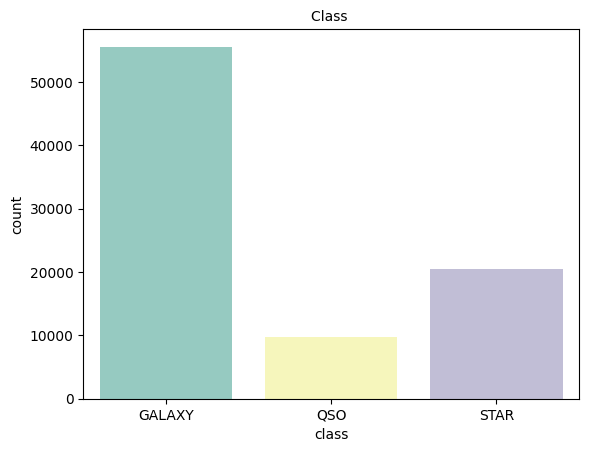

In [9]:
sns.countplot(x='class',data=df, palette="Set3")
plt.title("Class ",fontsize=10)
plt.show()

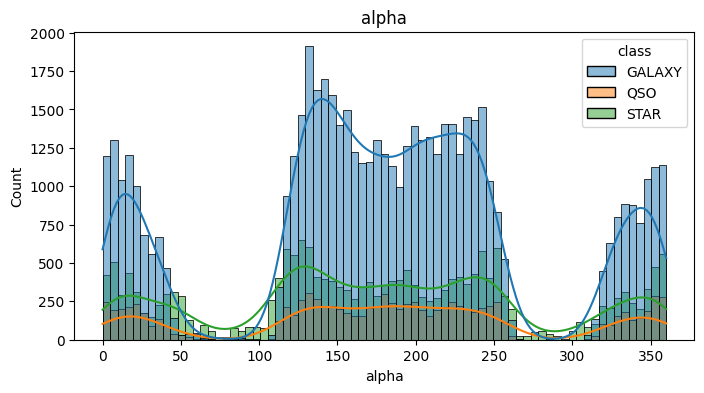

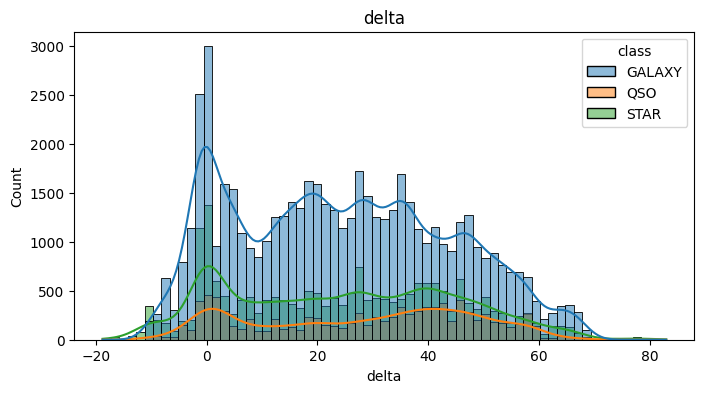

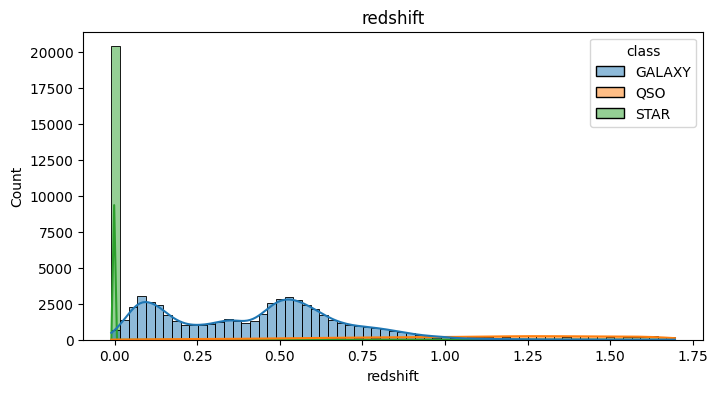

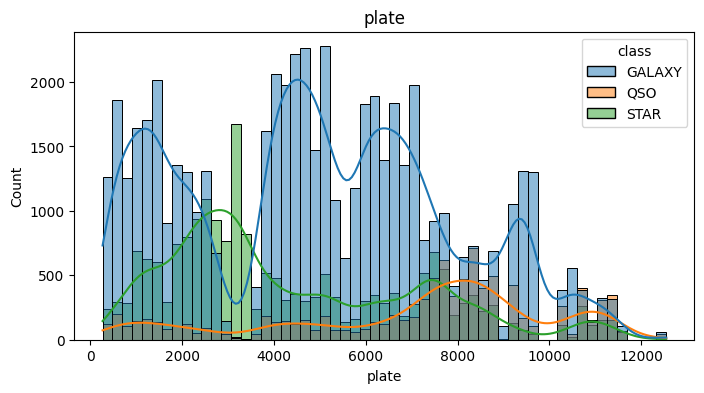

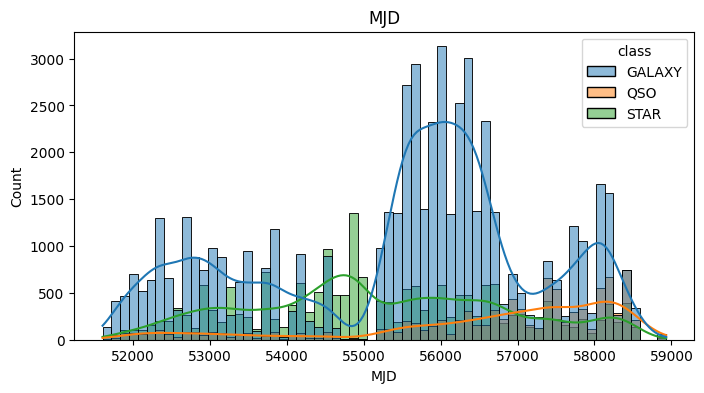

In [10]:
#We can train out models faster if we choose those features which can distinguish well between out classes.....
#As alpha, delta, u, g, r, i, z, redshift, plate, MJD are astronomical quantities, therefore, we'll keep them as our primary feature...

for i in ['alpha', 'delta','redshift', 'plate', 'MJD']:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df, x=i, kde=True, hue="class")
    plt.title(i)
    plt.show()

**Encode Target Variable**

In [11]:
df["class"]=[0 if i == "GALAXY" else 1 if i == "STAR" else 2 for i in df["class"]]

**Correlation analysis**

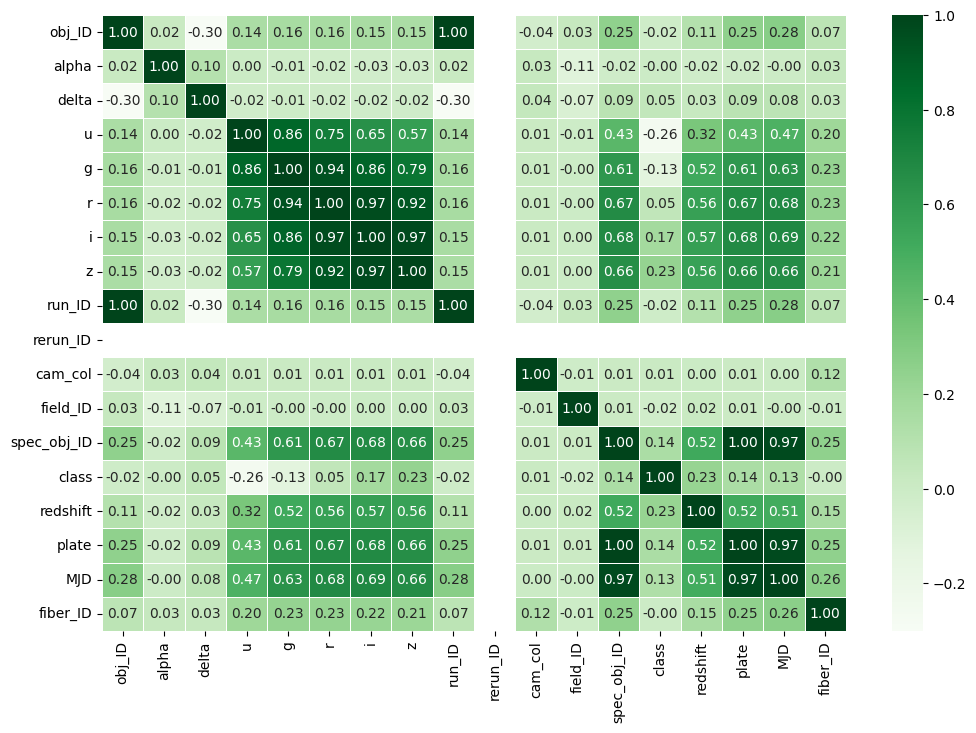

In [12]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="Greens", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

In [13]:
corr = df.corr()
corr["class"].sort_values()

u             -0.263240
g             -0.125921
field_ID      -0.022441
run_ID        -0.015620
obj_ID        -0.015619
alpha         -0.004961
fiber_ID      -0.004526
cam_col        0.013956
delta          0.046456
r              0.054022
MJD            0.131263
spec_obj_ID    0.143202
plate          0.143203
i              0.172127
redshift       0.226857
z              0.232381
class          1.000000
rerun_ID            NaN
Name: class, dtype: float64

In [14]:
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)

### Dealing with Imbalanced Data

In [15]:
X = df.drop(['class'], axis = 1)
y = df.loc[:,'class'].values

In [16]:
sm = SMOTE(random_state=42)
print('Original dataset shape %s' % Counter(y))
X, y = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y))

Original dataset shape Counter({0: 55585, 1: 20408, 2: 9741})
Resampled dataset shape Counter({0: 55585, 2: 55585, 1: 55585})


### Train / Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

### Data Scaling

In [18]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## Model Training

**K NEAREST NEIGHBORS**

In [19]:
knn1=KNeighborsClassifier(algorithm='auto',n_neighbors=9,weights='distance')
knn1.fit(X_train,y_train)
y_pred1=knn1.predict(X_test)

In [20]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71     13805
           1       0.72      0.68      0.70     13883
           2       0.72      0.70      0.71     14001

    accuracy                           0.70     41689
   macro avg       0.70      0.70      0.70     41689
weighted avg       0.70      0.70      0.70     41689



**Gaussian Naive Bayes**

In [21]:
nb=GaussianNB()
nb.fit(X_train,y_train)
y_pred2=nb.predict(X_test)

In [22]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.53      0.11      0.19     13805
           1       0.46      0.68      0.54     13883
           2       0.54      0.70      0.61     14001

    accuracy                           0.50     41689
   macro avg       0.51      0.50      0.45     41689
weighted avg       0.51      0.50      0.45     41689



**DECISION TREE CLASSIFIER**

In [23]:
dt=DecisionTreeClassifier(criterion='entropy',random_state=2,max_depth=10)
dt.fit(X_train,y_train)
y_pred3=dt.predict(X_test)

In [24]:
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     13805
           1       1.00      1.00      1.00     13883
           2       0.96      0.95      0.95     14001

    accuracy                           0.97     41689
   macro avg       0.97      0.97      0.97     41689
weighted avg       0.97      0.97      0.97     41689



**XG BOOST**

In [25]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
y_pred4=xgb.predict(X_test)

In [26]:
print(classification_report(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     13805
           1       0.99      1.00      1.00     13883
           2       0.97      0.96      0.96     14001

    accuracy                           0.97     41689
   macro avg       0.97      0.97      0.97     41689
weighted avg       0.97      0.97      0.97     41689



**Random Forest Classifier**

In [27]:
r_forest = RandomForestClassifier()
r_forest.fit(X_train,y_train)
y_pred6 = r_forest.predict(X_test)
score = r_forest.score(X_test, y_test)
rf_score_ = np.mean(score)

print('Accuracy : %.3f' % (rf_score_))

Accuracy : 0.978


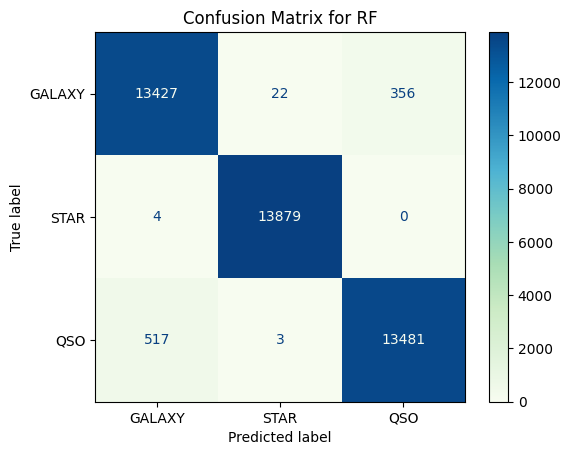

In [30]:
cm = confusion_matrix(y_test, y_pred6, labels=[0, 1, 2]) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['GALAXY', 'STAR', 'QSO'])
disp.plot(cmap='GnBu')
plt.title('Confusion Matrix for RF')
plt.show()

In [31]:
print(classification_report(y_test, y_pred6))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     13805
           1       1.00      1.00      1.00     13883
           2       0.97      0.96      0.97     14001

    accuracy                           0.98     41689
   macro avg       0.98      0.98      0.98     41689
weighted avg       0.98      0.98      0.98     41689



## Conclusion

**Random Forest** is providing the best results. i.e. 98% accuracy
& Classifying category STAR (1) with 100% Precision and Recall